In [1]:
import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import os

import torch

from scipy.io import loadmat

from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [4]:
# Add new methods here.
# methods = ['hesaff', 'hesaffnet', 'delf', 'delf-new', 'superpoint', 'd2-net', 'd2-net-trained']
# names = ['Hes. Aff. + Root-SIFT', 'HAN + HN++', 'DELF', 'DELF New', 'SuperPoint', 'D2-Net', 'D2-Net Trained']
# colors = ['black', 'orange', 'red', 'red', 'blue', 'purple', 'purple']
# linestyles = ['-', '-', '-', '--', '-', '-', '--']
# methods = ['hesaff', 'hesaffnet', 'delf', 'delf-new', 'superpoint', 'lf-net', 'd2-net', 'd2-net-ms', 'd2-net-trained', 'd2-net-trained-ms']
# names = ['Hes. Aff. + Root-SIFT', 'HAN + HN++', 'DELF', 'DELF New', 'SuperPoint', 'LF-Net', 'D2-Net', 'D2-Net MS', 'D2-Net Trained', 'D2-Net Trained MS']
# colors = ['black', 'orange', 'red', 'red', 'blue', 'brown', 'purple', 'green', 'purple', 'green']
# linestyles = ['-', '-', '-', '--', '-', '-', '-', '-', '--', '--']

methods = ['fr2d2','fr2d2f0','hardnet', 'hardnetf0','hardnetdice','czk','dice','jac','sqc']
names = ['fr2d2','fr2d2 f0', 'hardnet reliability','hardnet reliability f0', 'hardnet with dice', 'Czekanowski similarity', 'dice similiarity', 'Jaccard similarity','squared-chord similarity']
colors = ['black','grey','orange', 'yellow','red', 'blue', 'purple', 'green','brown']
linestyles = ['-', '--', '-','--', '--', '--', '--','--', '--', '--']

In [5]:
# Change here if you want to use top K or all features.
# top_k = 2000
top_k = None 

In [6]:
n_i = 52
n_v = 56

In [7]:
dataset_path = 'hpatches-sequences-release'

In [8]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [9]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [10]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a[matches[:, 0], : 2] 
            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [11]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )

In [12]:
def generate_read_function(method, extension='ppm'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function

In [13]:
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]

In [14]:
if top_k is None:
    cache_dir = 'cache'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [15]:
errors = {}

In [16]:
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if method == 'delf' or method == 'delf-new':
            read_function = generate_read_function(method, extension='png')
        else:
            read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

fr2d2
Loading precomputed errors...
# Features: 4857.819444 - [2613, 5000]
# Matches: Overall 1703.579630, Illumination 2005.653846, Viewpoint 1423.082143
fr2d2f0
Loading precomputed errors...
# Features: 4849.234568 - [2419, 5000]
# Matches: Overall 1689.218519, Illumination 1979.457692, Viewpoint 1419.710714
hardnet
Loading precomputed errors...
# Features: 4848.722222 - [2491, 5000]
# Matches: Overall 1713.064815, Illumination 2029.042308, Viewpoint 1419.657143
hardnetf0
Loading precomputed errors...
# Features: 4806.702160 - [2344, 5000]
# Matches: Overall 1718.016667, Illumination 1984.461538, Viewpoint 1470.603571
hardnetdice
Loading precomputed errors...
# Features: 4849.439815 - [2407, 5000]
# Matches: Overall 1735.429630, Illumination 2057.096154, Viewpoint 1436.739286
czk
Loading precomputed errors...
# Features: 4897.425926 - [3309, 5000]
# Matches: Overall 1638.472222, Illumination 1919.930769, Viewpoint 1377.117857
dice
Loading precomputed errors...
# Features: 4901.964506

# Plotting

In [17]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

fr2d2:  ['0.278', '0.701', '0.837', '0.865']
fr2d2 f0:  ['0.282', '0.704', '0.837', '0.865']
hardnet reliability:  ['0.281', '0.704', '0.838', '0.865']
hardnet reliability f0:  ['0.283', '0.704', '0.836', '0.864']
hardnet with dice:  ['0.279', '0.705', '0.840', '0.868']
Czekanowski similarity:  ['0.285', '0.709', '0.840', '0.866']
dice similiarity:  ['0.289', '0.716', '0.846', '0.872']
Jaccard similarity:  ['0.281', '0.706', '0.841', '0.868']
squared-chord similarity:  ['0.269', '0.664', '0.787', '0.812']


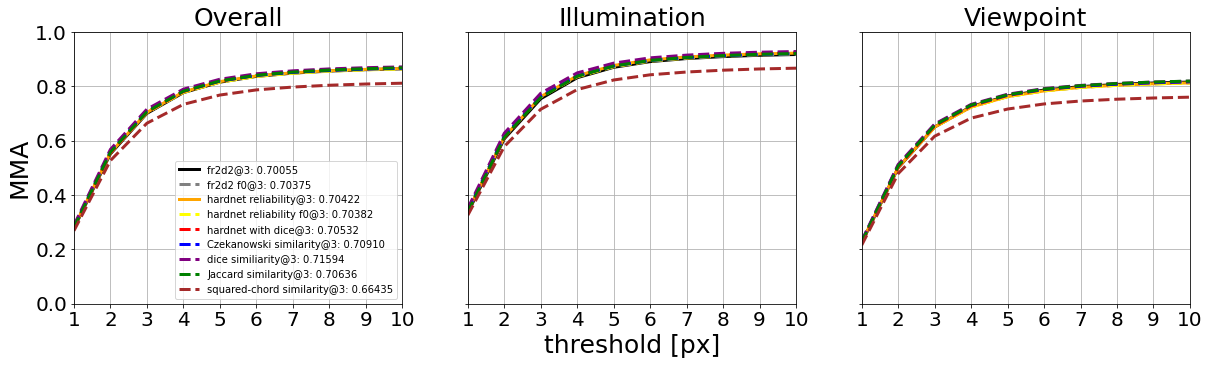

In [35]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=f'{name}@3: {(i_err[3] + v_err[3]) / ((n_i + n_v) * 5) :.5f}')
    print(f'{name}: ', [f'{(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) :.3f}' for thr in [1, 3, 6, 10]])
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

if top_k is None:
    plt.savefig('hseq.pdf', bbox_inches='tight', dpi=300)
else:
    plt.savefig('hseq-top.pdf', bbox_inches='tight', dpi=300)

In [19]:
loss_czk = np.array([[0.105, 0.640, 0.218, 0.963],
                     [0.105, 0.636, 0.217, 0.957],
                     [0.105, 0.634, 0.215, 0.955],
                     [0.103, 0.633, 0.213, 0.949],
                     [0.104, 0.632, 0.211, 0.947],])
loss_sqc = np.array([[0.107, 0.100, 0.878, 1.085],
                     [0.104, 0.081, 0.827, 1.012],
                     [0.104, 0.064, 0.827, 0.995],
                     [0.103, 0.063, 0.825, 0.990],
                     [0.102, 0.063, 0.823, 0.989],])
loss_jac = np.array([[0.103, 0.156, 0.367, 0.625],
                     [0.101, 0.151, 0.369, 0.622],
                     [0.102, 0.150, 0.371, 0.623],
                     [0.102, 0.150, 0.370, 0.622],
                     [0.102, 0.149, 0.371, 0.622],])
loss_dice = np.array([[0.101, 0.147, 0.295, 0.543],
                     [0.101, 0.146, 0.294, 0.542],
                     [0.103, 0.146, 0.294, 0.543],
                     [0.102, 0.146, 0.293, 0.542],
                     [0.100, 0.147, 0.292, 0.539],])
loss_hardnet = np.array([[0.102, 0.142, 0.287, 0.531],
                     [0.103, 0.143, 0.287, 0.532],
                     [0.103, 0.142, 0.287, 0.532],
                     [0.103, 0.143, 0.286, 0.531],
                     [0.100, 0.143, 0.285, 0.528],])
loss_hardnetdice = np.array([[0.104, 0.146, 0.296, 0.546],
                     [0.101, 0.146, 0.294, 0.542],
                     [0.103, 0.146, 0.294, 0.543],
                     [0.103, 0.146, 0.294, 0.543],
                     [0.101, 0.147, 0.292, 0.540],])
loss_hardnet_f0 = np.array([[0.199, 0.145, 0.382, 0.726],
                     [0.144, 0.147, 0.321, 0.611],
                     [0.133, 0.145, 0.311, 0.590],
                     [0.125, 0.145, 0.305, 0.575],
                     [0.122, 0.144, 0.302, 0.568],])
loss_original_f0 = np.array([[0.194, 0.141, 0.390, 0.725],
                     [0.142, 0.144, 0.324, 0.610],
                     [0.131, 0.144, 0.313, 0.587],
                     [0.127, 0.143, 0.308, 0.577],
                     [0.122, 0.143, 0.303, 0.569],]) 

losses = {'czk': loss_czk,
          'sqc': loss_sqc,
          'jac': loss_jac,
          'dice': loss_dice,
          'hardnet': loss_hardnet,
          'hardnet_dice': loss_hardnetdice,
          'hardnet_f0': loss_hardnet_f0,
          'original_f0': loss_original_f0}

In [20]:
times_czk = np.array([44*60+12, 44*60+52, 44*60+47, 44*60+29, 44*60+45])
times_sqc = np.array([44*60+8, 44*60+44, 45*60+22, 44*60+55, 45*60+6])
times_jac = np.array([44*60+56, 44*60+42, 45*60+45, 45*60+22, 45*60+12])
times_dice = np.array([44*60+43, 44*60+28, 45*60+12, 44*60+40, 44*60+50])
times_hardnet = np.array([44*60+46, 44*60+51, 44*60+54, 44*60+47, 45*60+0])
times_hardnetdice = np.array([44*60+32, 43*60+40, 44*60+3, 44*60+4, 44*60+43])
times_hardnet_f0 = np.array([44*60+25, 44*60+55, 45*60+6, 45*60+16, 45*60+26])
times_original_f0 = np.array([45*60+4, 45*60+12, 45*60+16, 45*60+5, 45*60+8])

times = {'czk': times_czk,
         'sqc': times_sqc,
         'jac': times_jac,
         'dice': times_dice,
         'hardnet': times_hardnet,
         'hardnet_dice': times_hardnetdice,
         'hardnet_f0': times_hardnet_f0,
         'original_f0': times_original_f0}

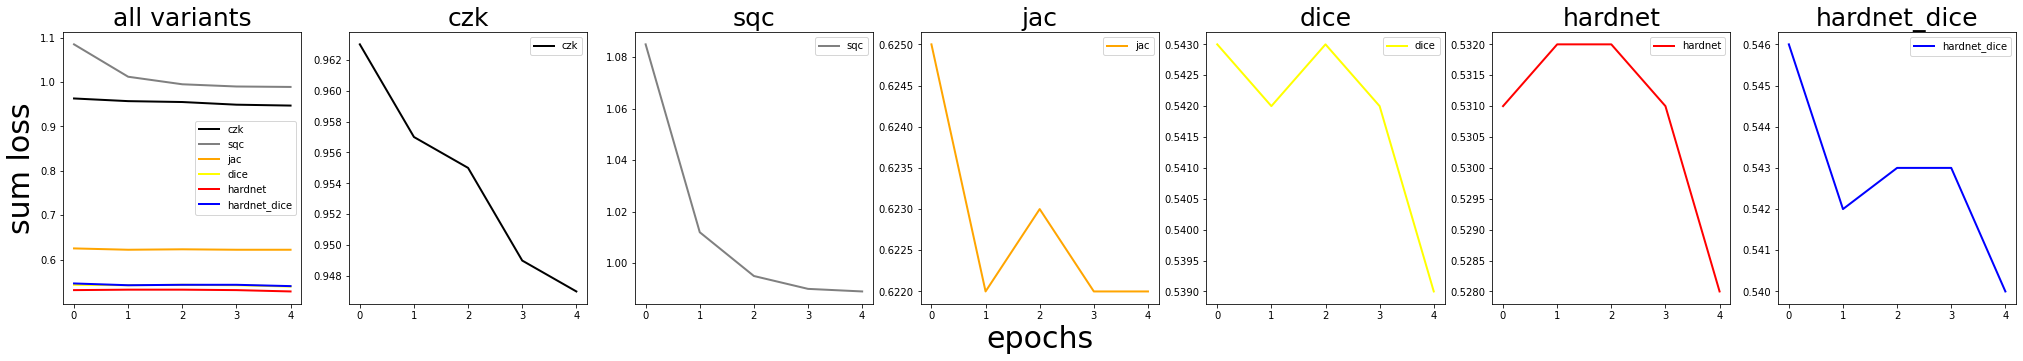

In [21]:
plt_x = np.arange(0, 5)
plt.figure(figsize=(35, 5))
for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    plt.subplot(1, 7, 1)
    plt.plot(plt_x, loss[:,3], color=colors[i], ls=linestyles[0], linewidth=2, label=method)
    plt.legend()
    plt.title('all variants')
    if i+1 == 1:
        plt.ylabel('sum loss', fontsize=30)
    if i+1 == 6:
        break

for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    plt.subplot(1, 7, i+2)
    plt.plot(plt_x, loss[:,3], color=colors[i], ls=linestyles[0], linewidth=2, label=method)
    plt.legend()
    plt.title(method)
    if i+1 == 3:
        plt.xlabel('epochs', fontsize=30)
    if i+1 == 6:
        break
# plt.legend()

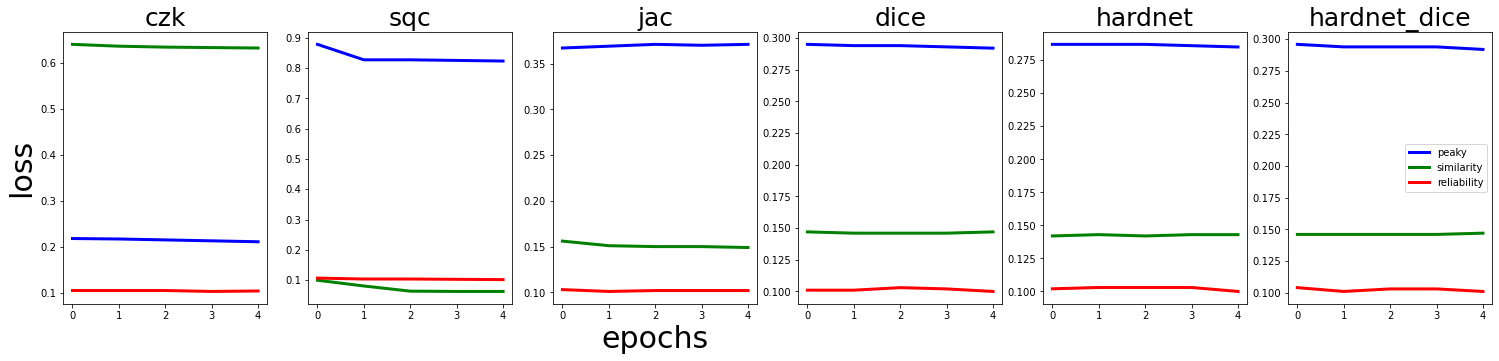

In [22]:
plt.figure(figsize=(30, 5))
for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    if i+1 == 7:      
        break
    plt.subplot(1, 7, i+1)
    
    # plt.plot(plt_x, loss[:,3], color=colors[0], ls=linestyles[i], linewidth=3, label='sum')
    plt.plot(plt_x, loss[:,2], color=colors[5], ls=linestyles[0], linewidth=3, label='peaky')
    plt.plot(plt_x, loss[:,1], color=colors[7], ls=linestyles[0], linewidth=3, label='similarity')
    plt.plot(plt_x, loss[:,0], color=colors[4], ls=linestyles[0], linewidth=3, label='reliability')
    
    plt.title(method)
    if i+1 == 3:
        plt.xlabel('epochs', fontsize=30)
    if i+1 == 1:
        plt.ylabel('loss', fontsize=30)

plt.legend()

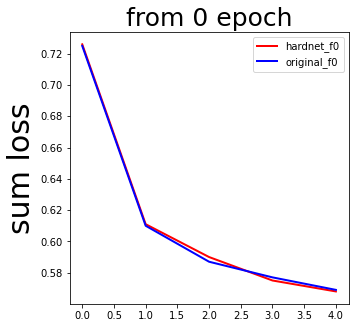

In [23]:
plt.figure(figsize=(5, 5))
for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    if i >= 6:
        plt.plot(plt_x, loss[:,3], color=colors[i-2], ls=linestyles[0], linewidth=2, label=method)
        plt.legend()
        plt.title('from 0 epoch')
    if i+1 == 1:
        plt.ylabel('sum loss', fontsize=30)

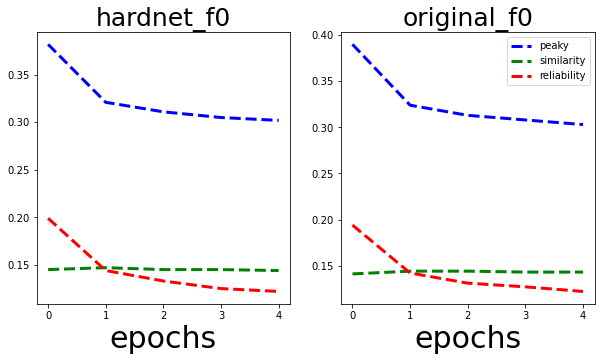

In [24]:
plt.figure(figsize=(10, 5))
for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    if i >= 6:
        plt.subplot(1, 2, i-5)
        # plt.plot(plt_x, loss[:,3], color=colors[0], ls=linestyles[i], linewidth=3, label='sum')
        plt.plot(plt_x, loss[:,2], color=colors[5], ls=linestyles[i], linewidth=3, label='peaky')
        plt.plot(plt_x, loss[:,1], color=colors[7], ls=linestyles[i], linewidth=3, label='similarity')
        plt.plot(plt_x, loss[:,0], color=colors[4], ls=linestyles[i], linewidth=3, label='reliability')
        
        plt.title(method)
        plt.xlabel('epochs', fontsize=30)
        if i == 5:
            plt.ylabel('loss', fontsize=30)

plt.legend()

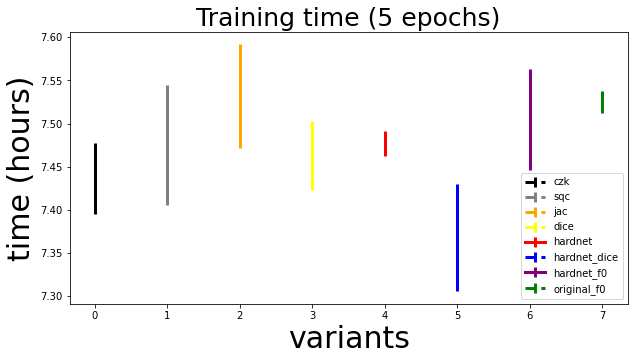

In [25]:
plt.figure(figsize=(10, 5))
for i, (method, loss, time) in enumerate(zip(losses.keys(), losses.values(), times.values())):
    # plt.plot(plt_x, loss[:,3], color=colors[0], ls=linestyles[i], linewidth=3, label='sum')
    plt.errorbar(i, 10*np.mean(time)/3600, 10*np.std(time)/3600, color=colors[i], ls=linestyles[i-4], linewidth=3, label=method)
    
    plt.title('Training time (5 epochs)')
    plt.xlabel('variants', fontsize=30)
    plt.ylabel('time (hours)', fontsize=30)

plt.legend()